# **Implied Volatility Surface Modelling**

In [2]:
%load_ext autoreload
%autoreload 2

import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from abc import ABC, abstractmethod
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple
from scipy.interpolate import griddata, interp1d, PchipInterpolator
from scipy.optimize import differential_evolution, minimize

import utility.plot_helpers as ph

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
file = "data/intermediate/full_spx_options_2023.parquet"

cols = [
    "strike", "underlying_last", 
    "dte", "expiry",
    "c_delta", "p_delta", 
    "c_iv", "p_iv",
    "c_last", "p_last",
    "c_volume", "p_volume",
    "c_bid", "c_ask",
    "p_bid", "p_ask"
]

options = pd.read_parquet(file, columns=cols)
options["T"] = options["dte"] / 252 # Time to expity in years
options["k"] = np.log(
    options["strike"] / options["underlying_last"] # log moneyness
 )
options

,strike,underlying_last,dte,expiry,c_delta,p_delta,c_iv,p_iv,c_last,p_last,c_volume,p_volume,c_bid,c_ask,p_bid,p_ask,T,k
date,,,,,,,,,,,,,,,,,,
2023-01-04,1000.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,8.17536,3041.37,0.03,1.0,7.0,2846.8,2848.3,0.0,0.05,0.000000,-1.348953
2023-01-04,1200.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,7.06724,0.00,0.00,1.0,0.0,2646.8,2648.3,0.0,0.05,0.000000,-1.166632
2023-01-04,1400.0,3853.39,0.0,2023-01-04,1.00000,-0.00025,NaN,6.13893,0.00,0.00,0.0,0.0,2427.6,2471.0,0.0,0.05,0.000000,-1.012481
2023-01-04,1600.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,5.33125,2417.29,0.00,1.0,0.0,2246.8,2248.3,0.0,0.05,0.000000,-0.878950
2023-01-04,1800.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,4.61644,0.00,0.00,0.0,0.0,2046.8,2048.3,0.0,0.05,0.000000,-0.761167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,7200.0,4772.17,2184.0,2029-12-21,0.29633,-1.00000,0.17401,NaN,0.00,0.00,0.0,0.0,286.8,366.8,1550.9,1630.90,8.666667,0.411280
2023-12-29,7400.0,4772.17,2184.0,2029-12-21,0.27129,-1.00000,0.17063,NaN,0.00,0.00,0.0,0.0,245.4,325.4,1669.0,1749.00,8.666667,0.438679
2023-12-29,7600.0,4772.17,2184.0,2029-12-21,0.24709,-1.00000,0.16688,NaN,0.00,0.00,0.0,0.0,208.7,288.7,1791.8,1871.80,8.666667,0.465347


In [4]:
# Calibration day
date = '2023-12-20'
options_red = options[options.index == date]

In [5]:
class IVSurfaceModel(ABC):
    """Abstract base for any IV‐surface model."""
    def __init__(self):
        # once you fit, we’ll remember the spot price
        self._spot: float = None
        self._last_market = None
        
    @staticmethod
    def prepare_iv_surface(options: pd.DataFrame):
        df = options.copy()

        # choose OTM vol
        df['iv_smile'] = np.where(
            df['strike'] < df['underlying_last'], 
            df['p_iv'],
            np.where(
                df['strike'] > df['underlying_last'], 
                df['c_iv'], 
                0.5*(df['c_iv'] + df['p_iv'])
            )
        )
        df['k'] = np.log(df['strike'] / df['underlying_last'])
        df['w'] = df['iv_smile']**2 * df['T'] # total variance

        return df
    
    @staticmethod
    def _moneyness_band(T):
        """Return (m_lo, m_hi) given T in years."""
        days = T * 252
        if days < 7:
            return 0.90, 1.05
        elif days < 30:
            return 0.85, 1.15
        elif days < 180:
            return 0.80, 1.20
        else:
            return 0.70, 1.30

    @abstractmethod
    def fit(self, market_data: pd.DataFrame) -> None:
        """Calibrate to raw market quotes (DataFrame of k, T, σ_mkt)."""
        pass

    @abstractmethod
    def _implied_total_variance(self, k: np.ndarray, T: np.ndarray) -> np.ndarray:
        """Return total variance w(k,T)."""
        pass
    
    def implied_vol(self, K: np.ndarray, T: np.ndarray) -> np.ndarray:
        if self._last_market is None:
            raise RuntimeError("You must .fit(...) first to")

        K_arr = np.atleast_1d(K).astype(float)
        T_arr = np.atleast_1d(T).astype(float)
        spot = self._last_market["underlying_last"].iloc[0]
        k_arr = np.log(K_arr / spot)

        W = self._implied_total_variance(k_arr, T_arr) # (nT, nK)

        if W.ndim == 2 and T_arr.ndim == 1:
            T_arr = T_arr[:, None]

        iv = np.sqrt(W / T_arr)
        return iv.item() if iv.size == 1 else iv
    
    def check_arbitrage(self,
                        n_k:int=201,           # grid density in k
                        n_T:int=120,           # extra grid steps in T
                        k_pad:float=0.05,      # extend k-range slightly
                        tol:float=1e-10        # numerical tolerance
                    ):
        """
        Static-arbitrage diagnostics.
        Returns (ok, report_df) where ok=True if no violation.
        """
        if self._last_market is None:
            raise RuntimeError("You must .fit(...) first to")
        
        # ---------- build k,T grid covering fitted region -----------
        # maturities we actually calibrated
        df = self._last_market
        k = df["k"]

        T_slice = np.array(sorted(df["T"].unique()))
        T_min, T_max = T_slice.min(), T_slice.max()
        T_grid = np.concatenate([T_slice,
                                np.linspace(T_min, T_max, n_T)])
        T_grid = np.unique(np.round(T_grid, 6))      # drop duplicates

        k_min, k_max = k.min() - k_pad, k.max() + k_pad
        k_grid = np.linspace(k_min, k_max, n_k)

        W = self._implied_total_variance(k_grid, T_grid)   # (nT, nK)

        # ---------- butterfly test: ∂²w/∂k² >= 0 --------------
        dk = k_grid[1]-k_grid[0]
        dw2_dk2 = (W[:,2:] - 2*W[:,1:-1] + W[:,:-2]) / dk**2
        butterfly_ok = (dw2_dk2 >= -tol)

        # ---------- calendar test: ∂w/∂T >= 0 -----------------
        dT = np.diff(T_grid)
        dw_dT = (np.diff(W, axis=0).T / dT).T    # broadcast over k
        calendar_ok = (dw_dT >= -tol)

        # ---------- summary report -----------------------------
        bad_bfly = np.where(~butterfly_ok)
        bad_cal  = np.where(~calendar_ok)

        rows = []
        for r,c in zip(*bad_bfly):
            rows.append({"type":"butterfly",
                        "T":T_grid[r],
                        "k":k_grid[c+1],
                        "value":dw2_dk2[r,c]})
        for r,c in zip(*bad_cal):
            rows.append({"type":"calendar",
                        "T":(T_grid[r]+T_grid[r+1])/2,
                        "k":k_grid[c],
                        "value":dw_dT[r,c]})

        report = pd.DataFrame(rows) if rows else pd.DataFrame(
                columns=["type","T","k","value"])

        return report
    
    def plot_smiles(
            self,
            target_days=[1,5,10,15,20,25,30,40,50,60,126,252],
            total_var=False,
    ):
        """
        3×4 grid of IV(k) using the maturities closest to `target_days`.
        """
        if self._last_market is None:
            raise RuntimeError("You must .fit(...) first to")
        df = self._last_market.copy()
        df["days"] = (df["T"] * 252).round().astype(int)

        def closest_distinct(avail_days, targets):
            avail = np.asarray(sorted(avail_days))
            chosen = []
            for t in targets:
                if avail.size == 0:
                    chosen.append(None)            # placeholder -> blank subplot
                    continue
                idx = np.abs(avail - t).argmin()
                chosen.append(int(avail[idx]))
                avail = np.delete(avail, idx)      # no duplicates
            return chosen

        # choose the nearest available maturity for each target
        chosen_days = closest_distinct(df["days"].unique(), target_days)

        # build 3×4 grid
        fig, axes = plt.subplots(3, 4, figsize=(16, 9))
        axes = axes.flatten()

        for ax, D in zip(axes, chosen_days):
            if D is None:            # no maturity left—blank this cell
                ax.axis("off")
                continue

            T_i = D / 252.0
            slice_df  = df[np.isclose(df["T"], T_i)]
            
            m_lo, m_hi = self._moneyness_band(T_i)
            k_lo, k_hi = np.log(m_lo), np.log(m_hi)
            slice_df = slice_df[
                (slice_df["k"] >= k_lo) & 
                (slice_df["k"] <= k_hi)
            ].copy()
            
            k = slice_df["k"].values

            if total_var:
                model = slice_df["w"].values
                market = self._implied_total_variance(k, T_i).ravel()
            else:
                model = slice_df["iv_smile"].values
                market = self.implied_vol(slice_df["strike"], T_i).ravel()
            label = "TIVar" if total_var else "IV"

            ax.scatter(k, model, s=18, alpha=0.8, color="blue", label=f"Market {label}")
            ax.plot(k, market, color="red", label=f"Model {label}")
            ax.axvline(0, lw=.6, c="black", linestyle="--")

            ax.set_title(f"DTE = {int(D)}", fontsize=12)
            ax.set_xlabel("Log-Forward Moneyness (k)")
            title = "Total Implied Variance" if total_var else "Implied Volatility (IV)"
            ax.set_ylabel(f"{title}")
            ax.legend(loc="upper right")

        title = "SVI vs Market "
        title += "Total Implied Variances" if total_var else "Implied Volatilities"
        fig.suptitle(title, fontsize=18, y=1.02)
        fig.tight_layout()
        plt.show()

    def plot_surface(
        self,
        moneyness_band=(0.8, 1.2),
        dte_band=(1, 60),
        n_strikes=50,
        n_dtes=50,
        method_name=None,
        ax=None,
    ):
        if self._last_market is None:
            raise RuntimeError("You must .fit(...) first to")
        """Plot the full IV surface over strike and maturity."""
        df = self._last_market.copy()
        spot = df["underlying_last"].iloc[0]

        # filter maturities
        df['DTE'] = (df['T'] * 252).round().astype(int)
        valid = np.unique(df['DTE'])
        d_min, d_max = dte_band
        dtes = valid[(valid >= d_min) & (valid <= d_max)]
        if len(dtes)==0:
            raise ValueError("No expiries in dte_band")
        
        # build T grid in years
        T_grid = np.linspace(d_min/252, d_max/252, n_dtes)

        # determine strike band
        strikes_obs = df[df['DTE'].isin(dtes)]['strike']
        K_min = max(strikes_obs.min(), spot*moneyness_band[0])
        K_max = min(strikes_obs.max(), spot*moneyness_band[1])
        K_grid = np.linspace(K_min, K_max, n_strikes)

        # mesh and evaluate
        IV_mesh = self.implied_vol(K_grid, T_grid)
        K_mesh, T_mesh = np.meshgrid(K_grid, T_grid)

        if ax is None:
            fig = plt.figure(figsize=(12, 8))
            ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(
            K_mesh, T_mesh*252, IV_mesh,
            cmap='viridis', alpha=0.8, antialiased=True

        )

        for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
            ginfo = axis._axinfo["grid"]
            ginfo['color']     = (0.1, 0.1, 0.1, 0.2)
            ginfo['linewidth'] = 0.5
        
        ax.set_facecolor('white')
        ax.zaxis.labelpad = 10 
        ax.tick_params(axis='z', pad=6)
        ax.set_xlabel('Strike', fontsize=12)
        ax.set_ylabel('DTE (days)', fontsize=12)
        ax.set_zlabel('Implied Vol', fontsize=12)
        title = 'Implied Volatility Surface'
        title += f": {method_name}" if method_name else ""
        ax.set_title(title, fontsize=16, y=1.03)
        
        cbar = plt.colorbar(surf, ax=ax, pad=0.1, shrink=0.5, aspect=10)
        cbar.set_label('IV', rotation=0, labelpad=15)

        return ax

## **Non-parametric: Spline interpolation**


In [6]:
class InterpSurface(IVSurfaceModel):
    """
    Non-parametric interpolator for total implied variance w(k, T).
    - If only one unique T is provided, falls back to 1D interpolation in k.
    - Otherwise uses 2D griddata interpolation.
    """
    def __init__(self, method: str = 'cubic'):
        self.method = method
        self._1d_spline = None
        self._2d_data = None

    def fit(self, market_data: pd.DataFrame) -> None:
        """Fit the interpolator."""
        self._spot = market_data["underlying_last"].iloc[0]

        df = self.prepare_iv_surface(market_data)
        ks = df['k'].to_numpy()
        Ts = df['T'].to_numpy()
        ws = df['w'].to_numpy() # Total variance
        self._last_market = df.copy()

        unique_T = np.unique(Ts)
        if len(unique_T) == 1:
            # Single-maturity case: build a 1D spline in k
            order = np.argsort(ks)
            self._1d_spline = interp1d(
                ks[order], ws[order],
                kind=self.method,
                fill_value="extrapolate",
            )
        else:
            # Full-surface case: store the raw arrays for 2D interpolation
            self._2d_data = (ks, Ts, ws)

    def _implied_total_variance(self, k: np.ndarray, T: np.ndarray) -> np.ndarray:
        """Query the interpolated total variance w(k, T)."""
        if self._1d_spline is not None:
            # Only one maturity in fit → ignore T
            return self._1d_spline(k)
        
        # 2D interpolation via griddata
        ks, Ts, ws = self._2d_data
        pts = np.column_stack((ks, Ts))

        # 2) build a mesh of *query* k‐and‐T pairs
        Kq, Tq = np.meshgrid(k, T, indexing="xy")        # (len(T), len(k))
        qry = np.column_stack((Kq.ravel(), Tq.ravel())) # (len(T)*len(k), 2)

        # 3) interpolate and reshape back into (len(T), len(k))
        Wq = griddata(pts, ws, qry, method=self.method)
        return Wq.reshape(len(T), len(k))

In [7]:
interp_iv = InterpSurface(method='linear')
interp_iv.fit(options_red)

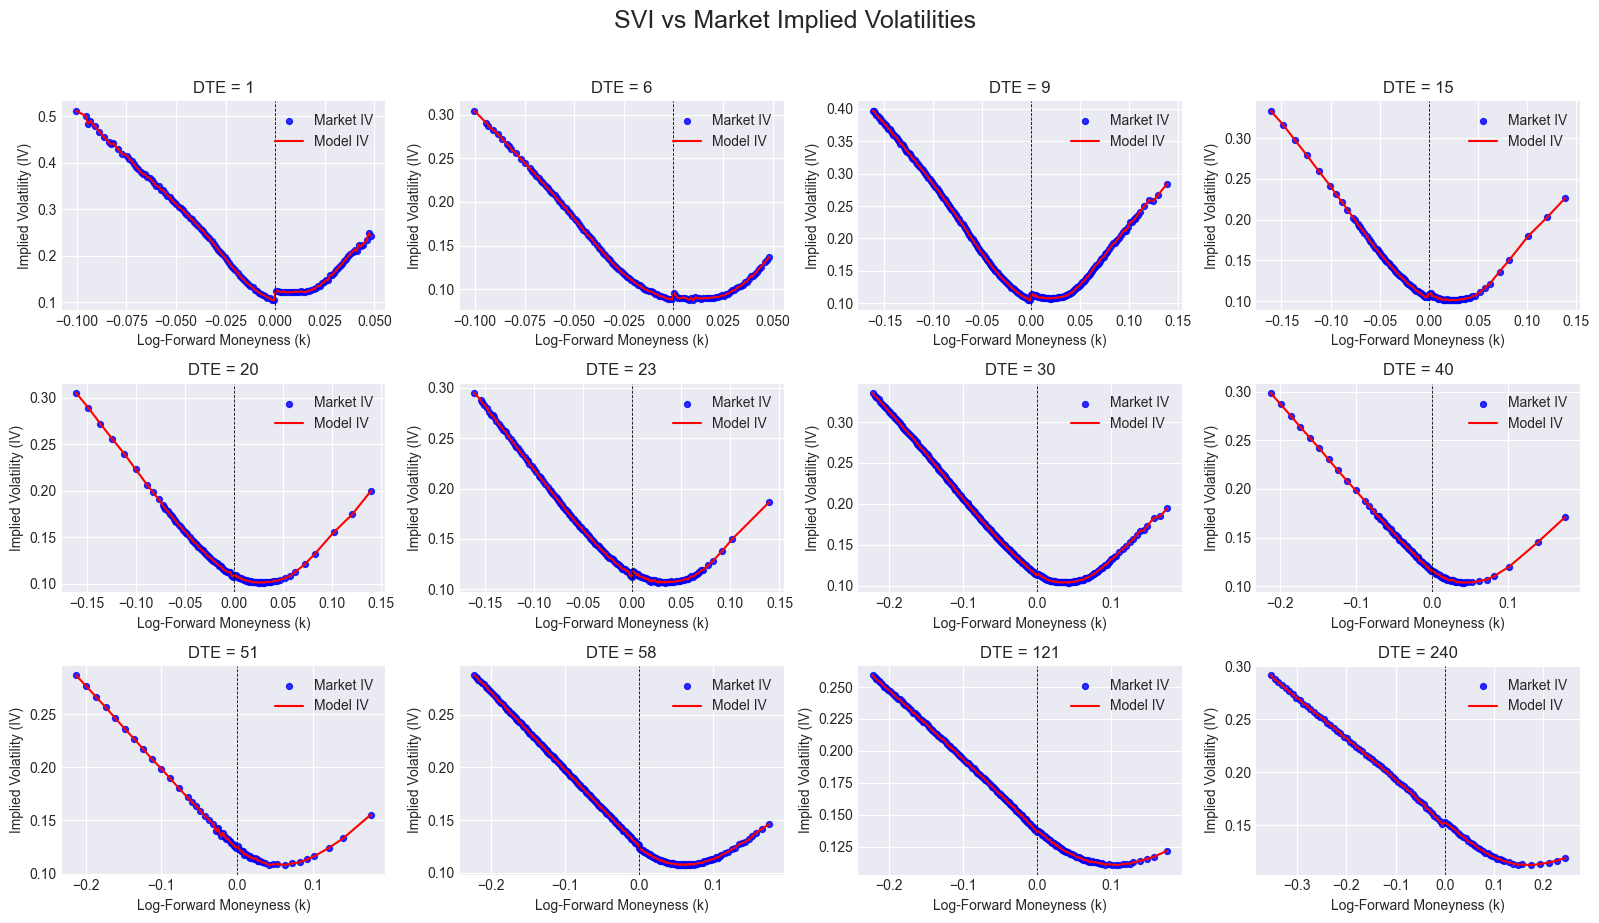

In [8]:
interp_iv.plot_smiles()

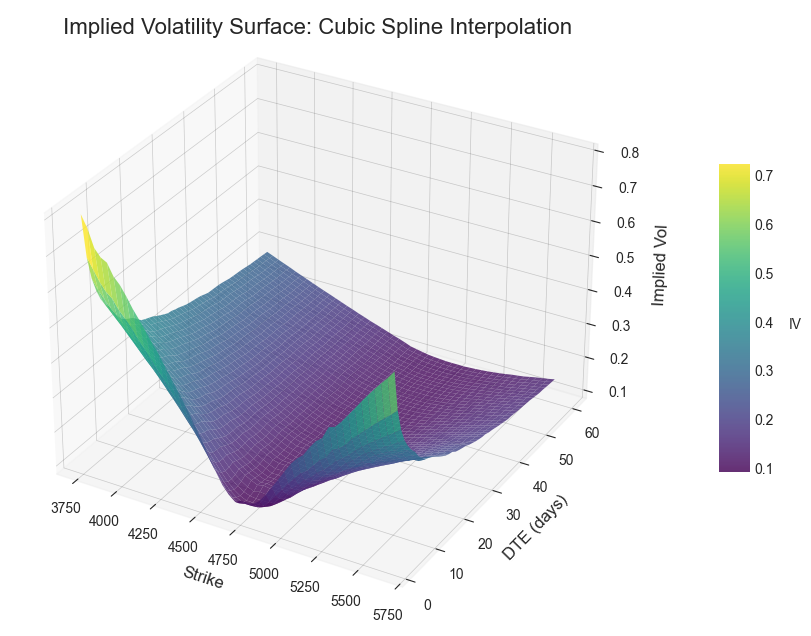

In [9]:
interp_iv.plot_surface(
    method_name="Cubic Spline Interpolation",
    dte_band=(2,60),
)
plt.show()

## **Parametric: Stochastic Volatility Inspired (SVI) model**

In [10]:
class SVI(IVSurfaceModel):
    """
    Per‐slice “raw” SVI with smooth interpolation of parameters across T.
    """
    param_names = ("a", "b", "rho", "m", "sigma")
    def __init__(self,
                 init_guess: dict = None,
                 atm_weighting: bool = True,
                 butterfly_arb_strict: bool = False,
                 enforce_calendar_arb: bool = False,
                 calendar_arb_weight=50,
                 calendar_arb_kcut=0.02,
                 interpolation_mode=None,  # 'params' or 'w'
                 bounds: dict = None,
                 use_dynamic_init_guess: bool = True,
                 use_dynamic_bounds: bool = True,
                 glob_solver_fallback: bool = True,
                 rmse_iv_recalib: float = 0.02,
                 max_abs_iv_recalib: float = 0.05,
                 maturity_band: Tuple = (1/252, 2),
                 min_pts: int = 6,
                 params_interp_kind: str = 'linear'):
        super().__init__()

        # default SVI parameter bounds for raw‐SVI slice calibration
        default_bounds = {
            'a':     (1e-6,   1.0),      # total variance offset
            'b':     (1e-2,   1.0),     # variance slope
            'rho':   (-0.999, 0.999),  # correlation
            'm':     (-1.0,   1.0),   # log-moneyness shift 
            'sigma': (1e-3,   1.0),  # controls smile curvature
        }

        self.init_guess_user = init_guess or {}  # user overrides
        self.atm_weighting = atm_weighting # decreasing weights from ATM to OTM
        self.butterfly_arb_strict = butterfly_arb_strict
        self.enforce_calendar_arb = enforce_calendar_arb 
        self.calendar_arb_weight         = calendar_arb_weight # strength of penalty (tune)
        self.calendar_arb_kcut           = calendar_arb_kcut
        self.interpolation_mode = interpolation_mode or (
            'w' if enforce_calendar_arb else 'params'
        )
        self.bounds = bounds or default_bounds
        self.use_dyn = use_dynamic_init_guess
        self.use_dynamic_bounds = use_dynamic_bounds
        self.glob_solver_fallback = glob_solver_fallback
        self.rmse_iv_recalib = rmse_iv_recalib
        self.max_abs_iv_recalib = max_abs_iv_recalib
        self.maturity_band = maturity_band
        self.params_interp_kind  = params_interp_kind
        self.min_pts  = min_pts  # min nb of calib points for the smile

        self.params_by_T  = {}      # raw SVI fits: T -> (a,b,rho,m,sigma)
        self._param_interp = {}    # after fit: name -> interp1d over T
        self.slice_stats = {}     # stores performance metrics per slice 


    # -------- Static helpers --------
    @staticmethod
    def _svi_raw(k, a, b, rho, m, sigma):
        """Raw SVI total‐variance formula:"""
        return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))
    

    # -------- Public API --------
    def fit(self, market_data: pd.DataFrame) -> None:
        """Calibrate one raw-SVI slice per quoted maturity and build
        interpolator between slices.
        """
        self._spot = market_data["underlying_last"].iloc[0]

        # --- prepare dataframe --------------------------------------
        df  = self.prepare_iv_surface(market_data)
        df  = df[df["T"].between(*self.maturity_band)].copy()
        self._last_market = df                                  

        # --- per-slice calibration ----------------------------------
        T_vals, param_list = [], []
        prev_k = np.linspace(-0.4, 0.4, 61) # common k-grid for calendar test
        prev_params=None

        for T_i, sl in df.groupby("T"):
            m_lo, m_hi = self._moneyness_band(T_i)
            k_lo, k_hi = np.log(m_lo), np.log(m_hi)
            sl = sl[(sl["k"] >= k_lo) & (sl["k"] <= k_hi)]

            if len(sl) < self.min_pts:
                continue

            params = self._calibrate_raw_svi(
                sl["k"].values, sl["w"].values, T_i,
                prev_params=prev_params if self.enforce_calendar_arb else None,
                prev_k=prev_k
            )

            self.params_by_T[T_i] = params
            T_vals.append(T_i)
            param_list.append(params)
            prev_params = params  # update “previous” slice

        if not T_vals:
            raise RuntimeError("No maturities left after filters")

        # --- unpack parameters --------------------------------------
        T_grid = np.asarray(T_vals)              # already ascending
        A, B, R, M, S = map(np.array, zip(*param_list))

        # ----------  parameter interpolators -----------------
        self._param_interp = {
            "a"    : interp1d(T_grid, A, kind=self.params_interp_kind,
                            fill_value="extrapolate"),
            "b"    : interp1d(T_grid, B, kind=self.params_interp_kind,
                            fill_value="extrapolate"),
            "rho"  : interp1d(T_grid, R, kind=self.params_interp_kind,
                            fill_value="extrapolate"),
            "m"    : interp1d(T_grid, M, kind=self.params_interp_kind,
                            fill_value="extrapolate"),
            "sigma": interp1d(T_grid, S, kind=self.params_interp_kind,
                            fill_value="extrapolate"),
        }

    def pooled_rmse_iv(self):
        """Pooled RMSE in IV space across all quotes and maturities."""
        if not hasattr(self, "slice_stats") or not self.slice_stats:
            return float("nan")
        N  = np.array([v["n"] for v in self.slice_stats.values()], dtype=float)
        R2 = np.array([v["rmse_iv"]**2 for v in self.slice_stats.values()], dtype=float)
        return float(np.sqrt(np.sum(N * R2) / np.sum(N)))


    # -------- Plotting methods --------
    def plot_params(self, ax=None):
        params = pd.DataFrame.from_dict(
            self.params_by_T,
            orient='index',
            columns=self.param_names
        )
        params.index.name = 'T'
        params = params.sort_index().reset_index()

        if ax is None:
            fig, ax = plt.subplots(figsize=(15, 7))

        for param in self.param_names:
            ax.plot(
                params['T'], params[param],
                marker='o', linestyle='-', label=param, alpha=0.8
            )

        ax.set_title('SVI Parameters vs. Maturity', fontsize=14)
        ax.set_xlabel('T (years)', fontsize=12)
        ax.set_ylabel('Parameter value', fontsize=12)
        ax.legend()
        ax.grid(True)
        plt.tight_layout()

        return ax
    
    def plot_total_variance_slices(self,
                                n_slices: int = 6,
                                k_band: tuple = (-0.2, 0.15),
                                nk: int = 201,
                                show_market: bool = True,
                                ax=None):
        if not self.params_by_T:
            raise RuntimeError("Fit the model first (params_by_T is empty).")

        # maturities sorted (smallest first) and take first n
        Ts = np.array(sorted(self.params_by_T.keys()))
        Ts = Ts[::5][:n_slices]
        
        kmin, kmax = k_band
        kg = np.linspace(kmin, kmax, nk)

        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))

        ax.axvline(0.0, color='gray', lw=1.0, alpha=0.6)

        for T_i in Ts:
            a,b,rho,m,sigma = self.params_by_T[T_i]
            w_model = self._svi_raw(kg, a,b,rho,m,sigma)
            ax.plot(kg, w_model, lw=2.0, label=fr"T={T_i:.4f} (~{int(round(T_i*252))}d)")

            if show_market and hasattr(self, "_last_market") and self._last_market is not None:
                sl = self._last_market[self._last_market["T"] == T_i]
                if len(sl):
                    mask = (sl["k"] >= kmin) & (sl["k"] <= kmax)
                    sl = sl.loc[mask]
                    ax.scatter(sl["k"], sl["w"], s=10, alpha=0.6)

        ax.set_xlabel(r"Log moneyness $k$")
        ax.set_ylabel("Implied Total Variance")
        ax.legend(title="", fontsize=9)
        ax.grid(True, alpha=0.25)
        plt.tight_layout()
        return ax


    # -------- Private helpers --------
    def _default_vector(self, k, w):
        """Return the 5-vector of slice-specific defaults."""
        if self.use_dyn:
            a0 = max(0.0, w.min())
            b0 = min((w.max()-w.min())/ (np.ptp(k)+1e-6), 0.10)
            m0 = k[np.argmin(w)]
            sigma0 = min(np.std(k)*0.1 + 1e-3, 0.10)
            dw_dk = np.gradient(w, k)[np.argmin(np.abs(k))]
            rho0  = np.clip(dw_dk/b0, -0.8, 0.4) if b0>0 else 0.0
        else:                              # static fall-back numbers
            a0, b0, rho0, m0, sigma0 = 0.01, 0.10, 0.0, 0.0, 0.05
        return dict(a=a0, b=b0, rho=rho0, m=m0, sigma=sigma0)

    def _initial_guesses(self, k, w):
        """Yield one np.array per Cartesian combination."""
        base = self._default_vector(k, w)

        # merge user overrides (scalar or iterable)
        param_lists = {}
        for name in self.param_names:
            if name in self.init_guess_user:
                user_val = self.init_guess_user[name]
                param_lists[name] = (user_val if isinstance(user_val,
                                         (list,tuple,np.ndarray))
                                     else [user_val])
            else:
                param_lists[name] = [base[name]]        # single default

        # Cartesian product over only those lists with >1 element
        for combo in itertools.product(*(param_lists[p] for p in self.param_names)):
            yield np.array(combo, float)

    def _slice_objective(self, params: np.ndarray,
                         k: np.ndarray,
                         w: np.ndarray,
                         T: float,
                         prev_params=None,
                         prev_k=None) -> float:
        """
        Objective for one raw‐SVI slice: weighted SSE + optional
        calendar & butterfly arbitrage constraints .
        """
        a, b, rho, m, sigma = params
        model = self._svi_raw(k, a, b, rho, m, sigma)
        resid = model - w

        # ------------- ATM weighting -----------------
        if self.atm_weighting:
            eps = 0.01 if T <= 0.05 else 0.05
            weights = 1.0 / (np.abs(k) + eps)**2 if T <= 0.05 else 1.0 / (np.abs(k) + eps)
        else:
            weights = 1.0

        sse = float(np.sum(weights * resid**2))

        # ------------- strict butterfly (Ferhani 2020) ----
        if self.butterfly_arb_strict:
            # wing slopes
            C_p, C_m  = b * (rho + 1), b * (rho - 1)
            # intercepts
            D_p, D_m  = a - m * C_p, a - m * C_m
            
            # butterfly check
            ok = (0 < C_p**2 < 4 and 0 < C_m**2 < 4 and
                D_p*(4-D_p) > C_p**2 and D_m*(4-D_m) > C_m**2)
            if not ok:
                return 1e10
            
        # ------------- enforce calendar arbitrage between slices -------
        if self.enforce_calendar_arb and prev_params is not None:
            # evaluate both slices on the shared k-grid
            a0,b0,r0,m0,s0 = prev_params
            w_prev = self._svi_raw(prev_k, a0,b0,r0,m0,s0)
            w_curr = self._svi_raw(prev_k, a ,b ,rho,m ,sigma)

            # hinge: only penalize where current < previous
            viol = np.maximum(w_prev - w_curr, 0.0)

            # focus on the right wing if you want
            if self.calendar_arb_kcut is not None:
                wing_mask = (prev_k >= self.calendar_arb_kcut).astype(float)
                viol *= wing_mask

            # scale-invariant weight
            lam = self.calendar_arb_weight / max(np.mean(w_prev), 1e-8)
            sse += lam * float(np.sum(viol**2))

        return sse
    
    def _compute_slice_metrics(self, k, w, T, params):
        """Compute IV / w errors for a slice and return a dict."""
        a,b,rho,m,sigma = params
        w_model  = self._svi_raw(k, a,b,rho,m,sigma)

        # guard small T
        T_eff    = max(float(T), 1e-16)
        sig_mkt  = np.sqrt(np.maximum(w, 0.0) / T_eff)
        sig_mdl  = np.sqrt(np.maximum(w_model, 0.0) / T_eff)

        err_iv   = sig_mkt - sig_mdl
        err_w    = w - w_model

        metrics = dict(
            n        = int(len(k)),
            rmse_iv  = float(np.sqrt(np.mean(err_iv**2))),
            max_abs_iv= float(np.max(np.abs(err_iv))),
            rmse_w   = float(np.sqrt(np.mean(err_w**2))),
        )
        return metrics
    
    def _calibrate_raw_svi(self, k, w, T, prev_params=None, prev_k=None):
        lb = np.array([self.bounds[n][0] for n in self.param_names])
        ub = np.array([self.bounds[n][1] for n in self.param_names])

        obj = lambda p: self._slice_objective(
            p, k, w, T,
            prev_params=prev_params,
            prev_k=prev_k
        )

        if self.use_dynamic_bounds:
            ub[0] = 0.5*np.max(w)  # a <= 1/2*max(w)
            lb[3] = 2*np.min(k)    # 2*np.min(k) <= m <= 2*np.max(k)
            ub[3] = 2*np.max(k)
            lb[1] = 1e-2

            if T < 0.05: # ≈ 13 DTE
                lb[3], ub[3] = -0.3, 0.3  # tighter m-bounds 

        # ------------- local solver -------------
        best = None
        for x0 in self._initial_guesses(k, w):
            x0 = np.clip(x0, lb, ub)
            sol = minimize(fun=obj,
                           x0=x0, 
                           bounds=list(zip(lb,ub)),
                           method="L-BFGS-B",
                           options={"maxiter": 1000})
            if sol.success and (best is None or sol.fun < best.fun):
                best = sol

        if best is None:
            raise RuntimeError("SVI slice failed for all initial guesses")
    
        # metrics for local solution
        local_params  = best.x
        local_metrics = self._compute_slice_metrics(k, w, T, local_params)

        # early exit if good enough or no global fallback
        if (not self.glob_solver_fallback) or (
            local_metrics["rmse_iv"] < self.rmse_iv_recalib and
            local_metrics["max_abs_iv"] < self.max_abs_iv_recalib
        ):
            self.slice_stats[T] = local_metrics
            return tuple(local_params)           

        # ------------- global DE + polish  -----------
        de = differential_evolution(
            obj,
            bounds=list(zip(lb,ub)),
            strategy='best1bin', popsize=15, maxiter=150,
            tol=1e-6,  mutation =(0.5, 1.0), recombination=0.7, 
            polish=False, # we'll polish ourselves
            disp=False,
            updating ='deferred' # faster in recent SciPy versions
        )
        pol = minimize(
            fun=obj,
            x0=de.x, 
            bounds=list(zip(lb,ub)),
            method='L-BFGS-B', options={'maxiter':500}
        )

        # choose final by objective value (and compute metrics for it)
        if pol.success and pol.fun < best.fun:
            final_params  = pol.x
            final_metrics = self._compute_slice_metrics(k, w, T, final_params)
        else:
            final_params  = local_params
            final_metrics = local_metrics

        self.slice_stats[T] = final_metrics
        return tuple(final_params)

    def _w_between_slices(self, k: np.ndarray, T: np.ndarray, atol=1e-10):
        """
        Calendar-safe interpolation of total variance in T between raw-SVI slices.
        """
        k = np.atleast_1d(k).astype(float)
        Tq = np.atleast_1d(T).astype(float)

        # sorted slices and params
        Ts = np.array(sorted(self.params_by_T.keys()))
        if Ts.size < 2:
            raise RuntimeError("Need at least two calibrated slices to interpolate in T.")
        
        # For each query T, find bracketing indices
        idx = np.searchsorted(Ts, Tq, side="right") - 1
        idx = np.clip(idx, 0, len(Ts)-2)
        T0 = Ts[idx]
        T1 = Ts[idx+1]

        # Snap-to-knot: if T is (numerically) exactly a slice, evaluate that slice
        exact0 = np.isclose(Tq, T0, atol=atol)
        exact1 = np.isclose(Tq, T1, atol=atol)

        lam = (Tq - T0) / (T1 - T0 + 1e-16)
        lam = np.maximum(lam, 0.0) # clamp to 0 below T0 and linear to T above T1

        # Gather parameters for both slices
        P0 = np.array([self.params_by_T[t] for t in T0]) # (nT, 5)
        P1 = np.array([self.params_by_T[t] for t in T1])

        # Evaluate both slices on the same k-mesh
        K, _ = np.meshgrid(k, Tq, indexing="xy") # (nT, nK)
        A0,B0,R0,M0,S0 = (P0[:,0,None], P0[:,1,None], P0[:,2,None], P0[:,3,None], P0[:,4,None])
        A1,B1,R1,M1,S1 = (P1[:,0,None], P1[:,1,None], P1[:,2,None], P1[:,3,None], P1[:,4,None])

        W0 = self._svi_raw(K, A0, B0, R0, M0, S0)
        W1 = self._svi_raw(K, A1, B1, R1, M1, S1)
        W  = (1.0 - lam)[:,None]*W0 + lam[:,None]*W1 # (nT, nK)

        # Overwrite exact rows with the exact slice evaluation (no FP drift)
        if exact0.any():
            rows = np.where(exact0)[0]
            for r in rows:
                W[r,:] = self._svi_raw(k, *self.params_by_T[T0[r]])
        if exact1.any():
            rows = np.where(exact1)[0]
            for r in rows:
                W[r,:] = self._svi_raw(k, *self.params_by_T[T1[r]])

        return W

    def _implied_total_variance(self, k, T):
        k = np.atleast_1d(k).astype(float)
        T = np.atleast_1d(T).astype(float)

        if self.interpolation_mode == 'params': # could use PCHIP instead
            # classic: interpolate a,b,rho,m,sigma then evaluate raw SVI
            a = self._param_interp['a'](T); b = self._param_interp['b'](T)
            rho = self._param_interp['rho'](T); m = self._param_interp['m'](T)
            sig = self._param_interp['sigma'](T)
            K,_ = np.meshgrid(k, T, indexing='xy')
            return self._svi_raw(K, a[:,None], b[:,None], rho[:,None], m[:,None], sig[:,None])

        elif self.interpolation_mode == 'w':
            # calendar-safe: piecewise-linear blend of w(k,T) between slices
            return self._w_between_slices(k, T)

        else:
            raise ValueError("interpolation_mode must be 'params' or 'w'")

In [11]:
init_guess = {"rho": [ -0.7, -0.5, -0.3, -0.1, 0.0]}
svi = SVI(init_guess=init_guess, enforce_calendar_arb=True, calendar_arb_weight=50)
svi.fit(options_red)
print(f"Pooled RMSE of Implied Volatility for SSVI model: {round(svi.pooled_rmse_iv(), 3)*100:.2f} %")

Pooled RMSE of Implied Volatility for SSVI model: 0.90 %


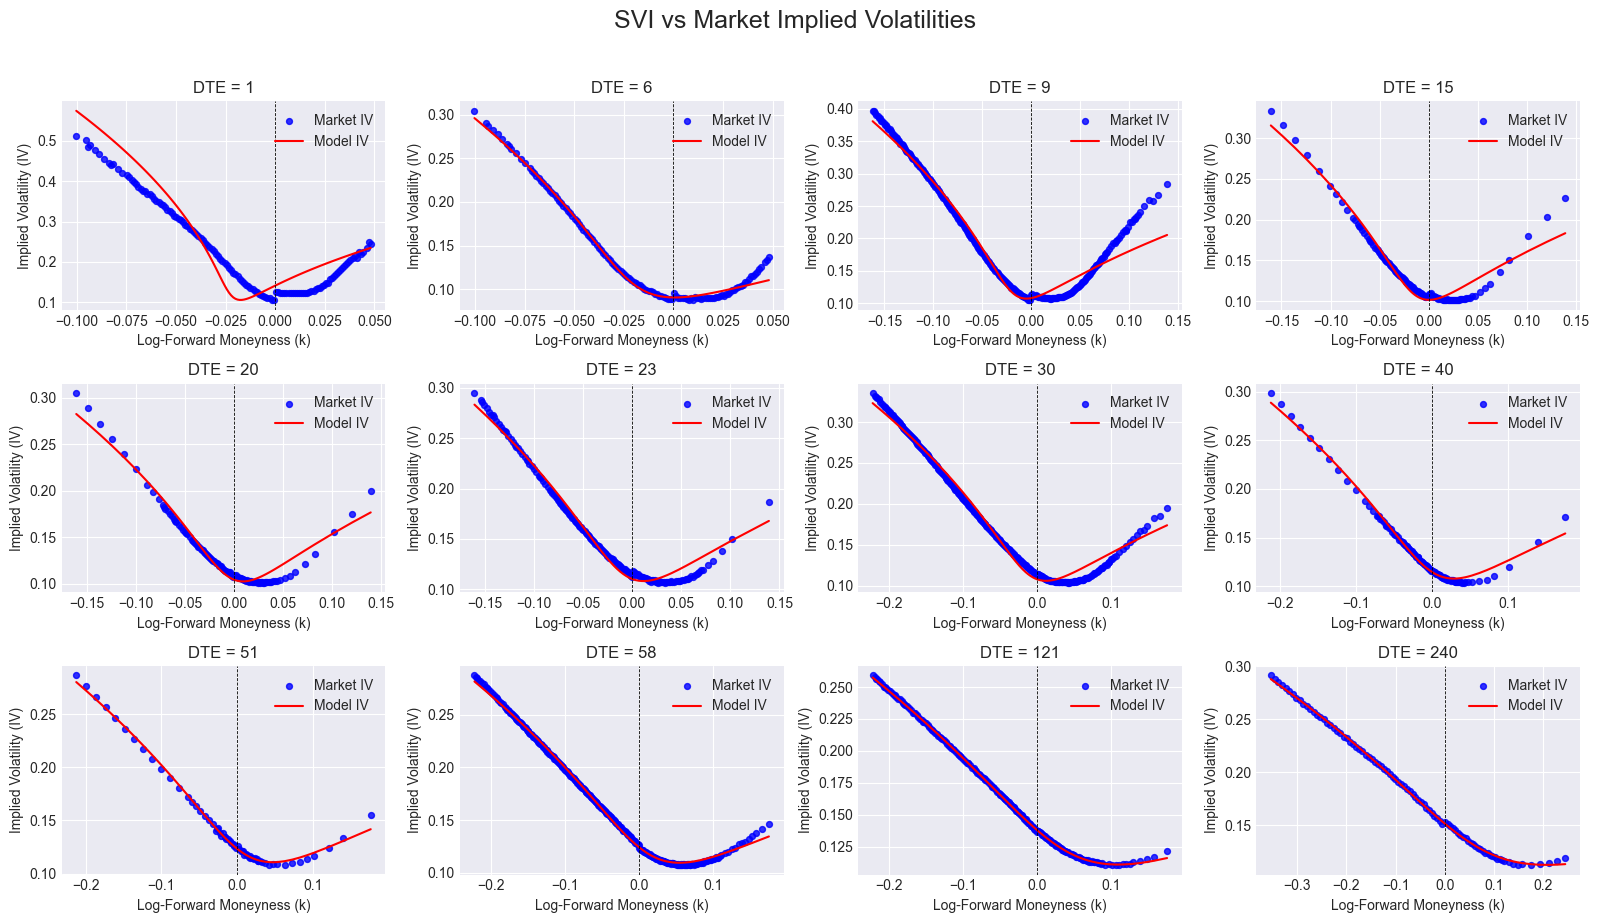

In [12]:
svi.plot_smiles()

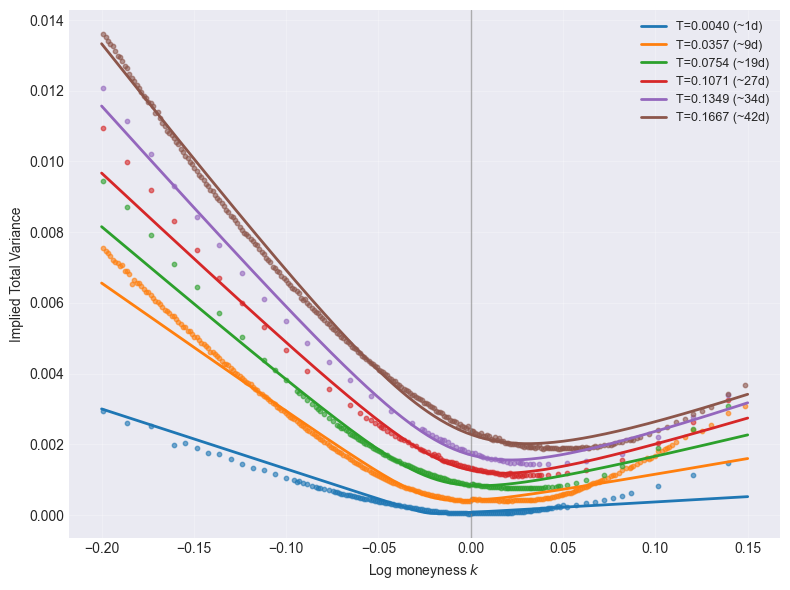

In [13]:
svi.plot_total_variance_slices()
plt.show()

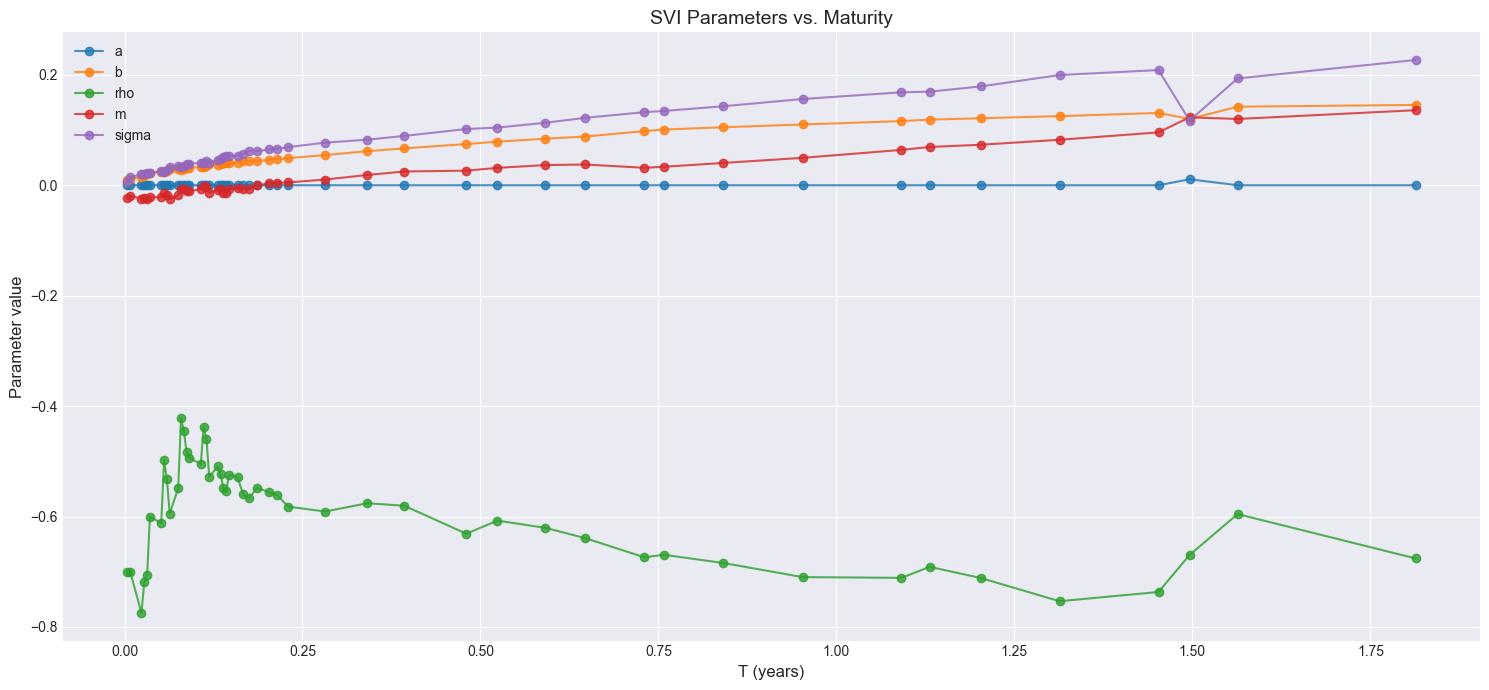

In [14]:
svi.plot_params()
plt.show()

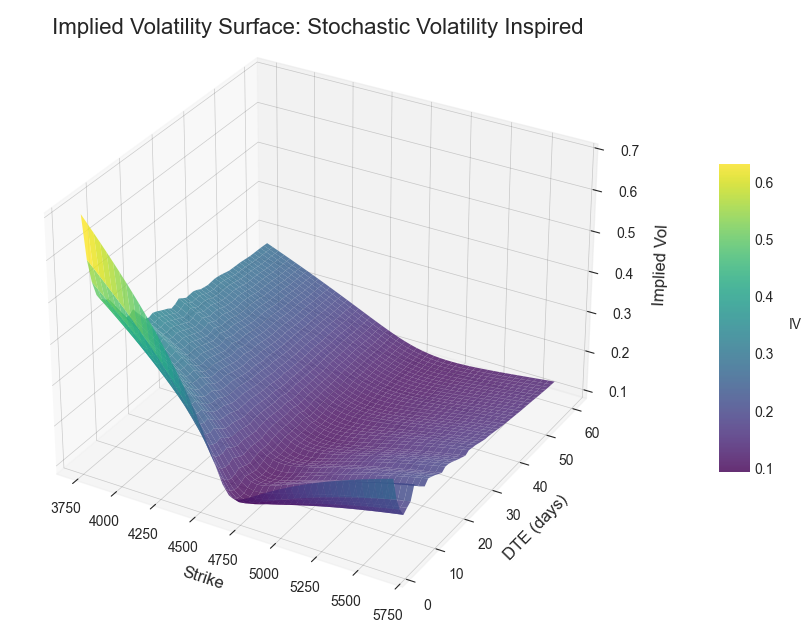

In [15]:
ax = svi.plot_surface(
    method_name="Stochastic Volatility Inspired",
    dte_band=(2 ,60)
)
plt.show()

In [16]:
arb_svi = svi.check_arbitrage()
arb_svi

,type,T,k,value
0,calendar,0.053572,-3.206607,-1.840129
1,calendar,0.053572,-3.186964,-1.828366
2,calendar,0.053572,-3.167320,-1.816604
3,calendar,0.053572,-3.147677,-1.804841
4,calendar,0.053572,-3.128034,-1.793079
...,...,...,...,...
3330,calendar,1.805889,0.643462,-0.016245
3331,calendar,1.805889,0.663105,-0.017352
3332,calendar,1.805889,0.682748,-0.018442
3333,calendar,1.805889,0.702391,-0.019514


In [17]:
print(f"Unique arbitrage type: {arb_svi["type"].unique()[0]}")

Unique arbitrage type: calendar


## **Parametric Extensions: Surface-SVI (SSVI) model**

In [ ]:
class SSVI(IVSurfaceModel):
    """
    SSVI (Surface SVI) fit:  w(k,T) = θ(T)/2 · Φ(k,θ; ρ,η,γ)
      Φ = 1 + ρ φ k + sqrt((φ k + ρ)^2 + 1 - ρ²)
      φ(θ) = η θ^{-γ}

    Guarantees static-and-calendar-arbitrage if
      Calendar-free arbitrage (both necessary and sufficient)
      1. θi+1 > θi for all i (True using cumul max of theta and monotone interpolation)
      2. 0 ≤∂θ(θϕ(θ)) ≤ 1 ρ2 1 + 1−ρ2 ϕ(θ), for all θ>0 

      Butterflt free arbitrage (only sufficient sufficient)
      3. θϕ(θ) (1 + |ρ|) <4, for all θ>0; 
      4. θϕ(θ)2 (1 + |ρ|) ≤4, for all θ>0;

      Using Power Law ofr phi:
      2. is always satisified ∂θ(θϕ(θ)) = 1-gamma <= upper blound for all gamma

      3. and 4. are satisfied by addign the constraint in the SSE
      #\eta \le \dfrac{4}{(1+|\rho|)\,\theta^{\,1-\gamma}}
      #\eta \le \dfrac{2}{\sqrt{(1+|\rho|)\,\theta^{\,1-2\gamma}}}
    """
    def __init__(self,
                 weight_mode="atm",          # weights in SSE
                 maturity_band : Tuple = (1/252, 2),
                 moneyness_band: Tuple = (0.75, 1.25),
        ):
        super().__init__()
        self.weight_mode = weight_mode
        self.maturity_band  = maturity_band
        self.moneyness_band = moneyness_band

        # will be filled by .fit()
        self.theta_interp   = None
        self.rho            = None
        self.eta            = None
        self.gamma          = None

        self._slice_stats = {} 

    # ---------- SSVI kernel ---------------------------------------------
    @staticmethod
    def _phi(theta, eta, gamma):
        return eta * theta**(-gamma)

    @classmethod
    def _w_ssvi(cls, k, theta, rho, eta, gamma):
        φ = cls._phi(theta, eta, gamma)
        return 0.5*theta*(1 + rho*φ*k + np.sqrt((φ*k + rho)**2 + 1 - rho**2))

    def fit(self, market_data: pd.DataFrame) -> None:
        self._spot = market_data["underlying_last"].iloc[0]
        df = self.prepare_iv_surface(market_data)

        # band filters ----------------------------------------------------
        min_T,max_T = self.maturity_band
        df = df[df["T"].between(min_T, max_T)]
        m_lo,m_hi   = self.moneyness_band
        k_lo,k_hi   = np.log(m_lo), np.log(m_hi)
        df = df[(df["k"].between(k_lo, k_hi))]
        self._last_market = df.copy()

        if df.empty:
            raise RuntimeError("No quotes after filters")

        # ---------- build θ(T) ---------------------------------------
        groups = {T: g for T, g in df.groupby("T")}
        T_grid = np.array(sorted(groups.keys()))

        # θ̂(T): ATM quadratic intercept (your existing estimator)
        theta_hat = []
        for T in T_grid:
            g = groups[T]
            th = self._estimate_theta_slice(g["k"].to_numpy(), g["w"].to_numpy())
            theta_hat.append(th)    
        theta_hat = np.asarray(theta_hat, float)
        theta_hat  = np.maximum.accumulate(theta_hat)                 # monotone
        self.theta_interp = PchipInterpolator(T_grid, theta_hat, extrapolate=True)

        # stack quotes
        k_all = df["k"].to_numpy()
        T_all = df["T"].to_numpy()
        w_all = df["w"].to_numpy()
        θ_all = self.theta_interp(T_all)
        weights = self._weights(k_all, θ_all)
        theta_max = np.max(θ_all)
        theta_min = np.max(θ_all)

        # -------- objective: SSE(w) + λ * SSE(skew_atm) -----------------
        def sse(x):
            rho, eta, gamma = x
            w_model = self._w_ssvi(k_all, θ_all, rho, eta, gamma)
            eta_cap_1 = 4.0 / ((1.0 + abs(rho)) * theta_max**(1.0 - gamma)) # tight for large theta,
            eta_cap_2 = 2.0 / np.sqrt((1.0 + abs(rho)) * theta_min**(1.0 - 2.0*gamma)) # tight for small theta if gamma > 0.5
            eta_cap   = min(eta_cap_1, eta_cap_2)
            eta = min(eta, eta_cap)
            #if not (eta < eta_cap_1 and eta <= eta_cap_2): # sufficient butt arb cond
            #    return 1e10
            
            # model w on all quotes
            return np.sum(weights * (w_model - w_all)** 2)

        # initial guess
        x0 = np.array([ -0.4,  0.5,  0.5])   # rho, eta, gamma
        bounds = [(-0.999,0.999),  # ρ
                  (1e-3, 2.0),     # η  (will be clipped below)
                  (1e-3, 0.999)]   # γ

        sol = differential_evolution(
                sse, bounds=bounds,
                strategy='best1bin', popsize=15, maxiter=150,
                tol=1e-7, polish=False
            )
        if not sol.success:
            raise RuntimeError(sol.message)

        self.rho, self.eta, self.gamma = sol.x

    def _weights(self, k, theta):
        if self.weight_mode == "uniform":
            return np.ones_like(k)
        if self.weight_mode == "atm":
            return 1.0/(np.abs(k)+0.05)
        if self.weight_mode == "atm_theta":
            return 1.0/(np.abs(k)+0.05) / np.sqrt(theta + 1e-8)
        raise ValueError("weight_mode must be 'uniform'|'atm'|'atm_theta'")

    def _estimate_theta_slice(self, k, w, band=0.05):
        m = np.abs(k) <= band
        if m.sum() < 5:
            return np.min(w)  # fallback
        X = np.c_[np.ones(m.sum()), k[m], k[m]**2]
        wt = 1.0/(np.abs(k[m])+1e-3)               # ATM-heavy weights
        beta = np.linalg.lstsq(X*wt[:,None], (w[m]*wt), rcond=None)[0]
        return float(beta[0])                       # intercept ~= θ̂

    def _implied_total_variance(self,
                                k: np.ndarray,
                                T: np.ndarray
                            ) -> np.ndarray:
        """
        Return w(k,T) with shape (len(T), len(k)).
        """
        k_arr = np.atleast_1d(k).astype(float)
        T_arr = np.atleast_1d(T).astype(float)

        # θ(T) from the monotone PCHIP
        theta = self.theta_interp(T_arr)          # (nT,)

        # broadcast via meshgrid
        K, Θ = np.meshgrid(k_arr, theta, indexing="xy")  # both (nT,nK)

        rho, eta, gamma = self.rho, self.eta, self.gamma
        return self._w_ssvi(K, Θ, rho, eta, gamma)    
    
    def pooled_rmse_iv(self) -> float:
        """
        One-number (pooled) RMSE in implied vol across all strikes & maturities.
        """
        if self._last_market is None:
            raise RuntimeError("Call fit(...) first; _last_market is empty.")

        df = self._last_market
        sse = 0.0
        N = 0.0

        for T_i, sl in df.groupby("T"):
            iv_market = sl["iv_smile"]
            iv_model = self.implied_vol(sl["strike"].to_numpy(), float(T_i)).ravel()
            err = iv_market - iv_model
            sse += float(np.sum(err**2))
            N += len(sl)

        return float(np.sqrt(sse / max(N, 1e-16)))

<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_3727/1235288848.py:2: SyntaxWarning: invalid escape sequence '\e'
  """


In [56]:
ssvi = SSVI(weight_mode="atm_theta")
ssvi.fit(options_red)
print(f"Pooled RMSE of Implied Volatility for SSVI model: {round(ssvi.pooled_rmse_iv(), 4)*100:.2f} %")

Pooled RMSE of Implied Volatility for SSVI model: 2.76 %


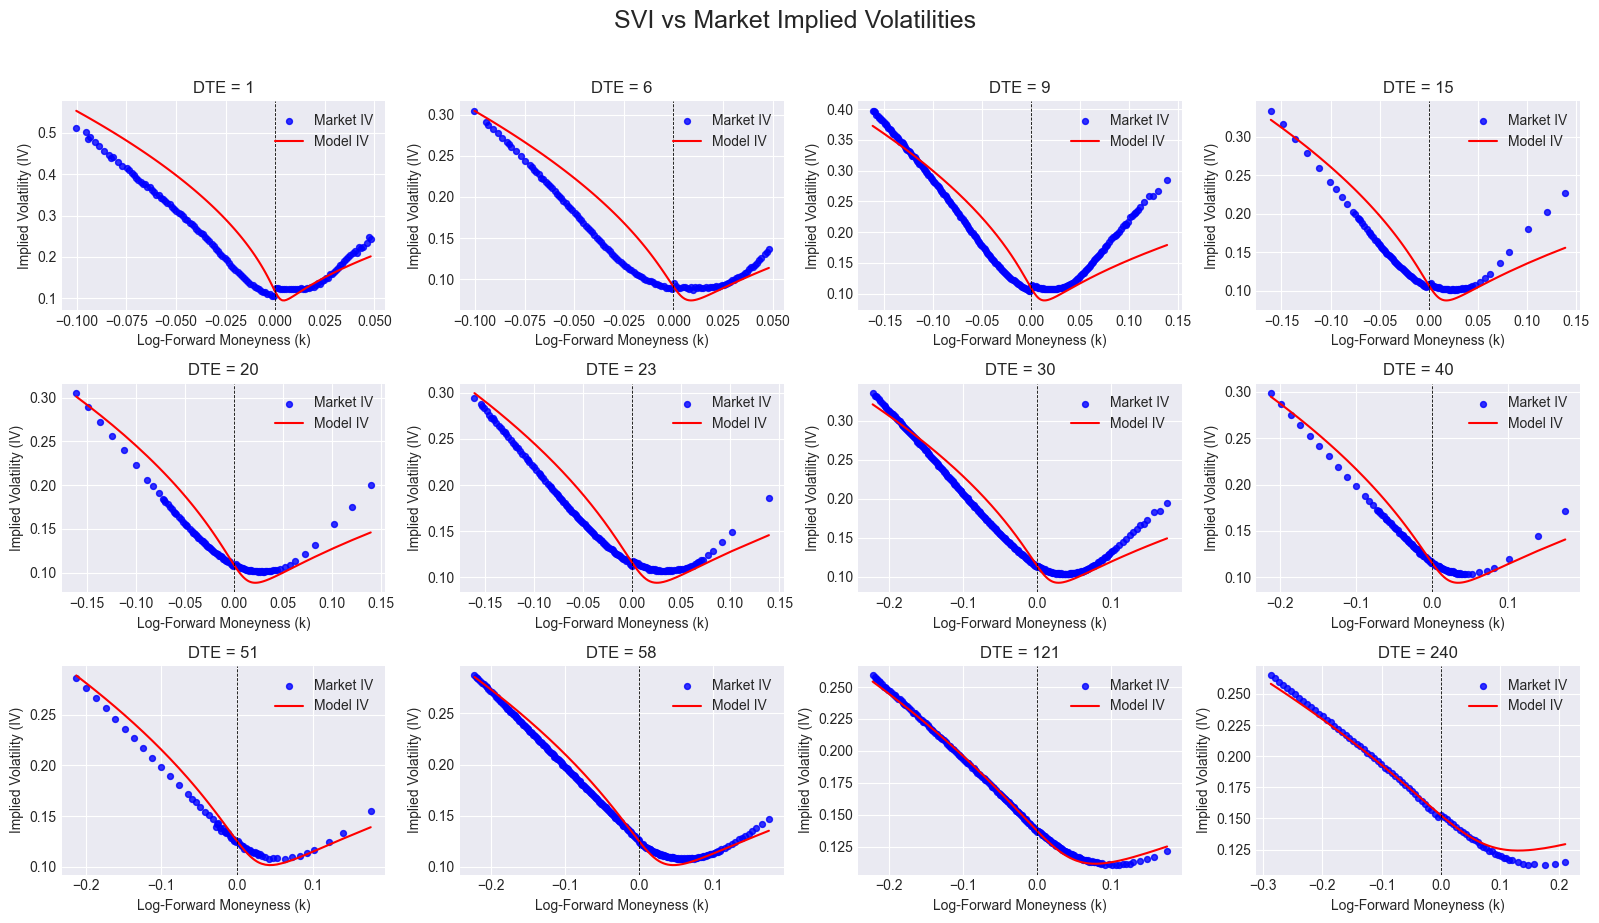

In [53]:
ssvi.plot_smiles()

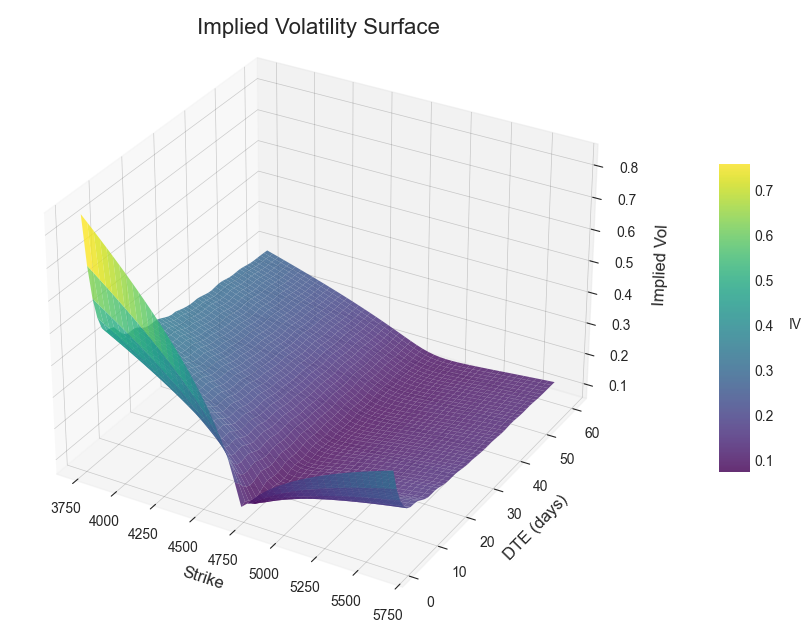

In [ ]:
ssvi.plot_surface()
plt.show()

In [57]:
ssvi.check_arbitrage()

,type,T,k,value


Now the volatility is free of static and calendar arbitrage, but at the expsense of poor smile fits because of the low dimensional parameterization (only 3 parameters) on the whole surface. 

## **Parametric Extensions: extended-SSVI (eSSVI) model**

In [64]:
class eSSVI(IVSurfaceModel):
    """
    eSSVI: SSVI with term structure of correlation rho = rho(theta).

    w(k,T) = θ(T)/2 * [ 1 + ρ(θ) φ(θ) k + sqrt( (φ(θ)k + ρ(θ))^2 + 1 - ρ(θ)^2 ) ]
      φ(θ)   = η θ^{-γ} (Power Law)
      ρ(θ)   = tanh(α + β θ) (Hyperbolic Tangent)

    Static/calendar no-arb (sufficient) are partly respected by:
      - θ(T) non-decreasing (we enforce via monotone cubic spline interp (PCHIP))
      - 0 < η ≤ 4 / (1 + sup_θ * sup_|ρ(θ)|) (we clip η to this cap )
    
    Since calendat arb conditons from SSVI cannot be applied to eSSVI because of the 
    time varying rho, we prevent most of the calendar arbitrage by smoothly penalizing 
    crossovers usign a Hinge loss. This prevents most of the cal arbitrages.

    For butterfly arbitrage we use conditons on the SSVI from Gatheral but 
    we use the max(rho(Theta)) instead of the constant rho.

    Note that recent papers (Pasquazzi 2023) provide necessary and sufficient conditions
    and might be used to completely remove any arbitrage.
    """
    def __init__(self,
                 weight_mode="atm",
                 maturity_band : tuple = (1/252, 2.0),
                 moneyness_band: tuple = (0.75, 1.25),
                 min_pts: int = 6):
        
        super().__init__()
        self.weight_mode = weight_mode
        self.maturity_band  = maturity_band
        self.moneyness_band = moneyness_band
        self.min_pts        = min_pts

        # learned after fit()
        self.theta_interp: PchipInterpolator = None
        self.alpha = None
        self.beta  = None
        self.eta   = None
        self.gamma = None

    # -------- kernel pieces --------
    @staticmethod
    def _phi(theta, eta, gamma):
        return eta * np.power(theta, -gamma)
    
    @staticmethod
    def _rho_theta(theta, alpha, beta):
        # bounded in (-1,1), smooth, monotone if beta has a sign
        return np.tanh(alpha + beta * theta)

    @classmethod
    def _w_esvvi(cls, k, theta, alpha, beta, eta, gamma):
        rho = cls._rho_theta(theta, alpha, beta)
        phi = cls._phi(theta, eta, gamma)
        return 0.5*theta * (1.0 + rho*phi*k + np.sqrt((phi*k + rho)**2 + 1.0 - rho**2))

    # -------- calibration --------
    def fit(self, market_data: pd.DataFrame) -> None:
        self._spot = market_data["underlying_last"].iloc[0]
        df = self.prepare_iv_surface(market_data)

        # filters
        tmin, tmax = self.maturity_band
        df = df[df["T"].between(tmin, tmax)]
        mlo, mhi = self.moneyness_band
        klo, khi = np.log(mlo), np.log(mhi)
        df = df[df["k"].between(klo, khi)]
        if self.min_pts > 0:
            df = df.groupby("T").filter(lambda g: len(g) >= self.min_pts)

        if df.empty:
            raise RuntimeError("No quotes after filters")
        self._last_market = df.copy()

        # ---------- build θ(T) ---------------------------------------
        groups = {T: g for T, g in df.groupby("T")}
        T_grid = np.array(sorted(groups.keys()))

        # θ̂(T): ATM quadratic intercept (your existing estimator)
        theta_hat = []
        for T in T_grid:
            g = groups[T]
            th = self._estimate_theta_slice(g["k"].to_numpy(), g["w"].to_numpy())
            theta_hat.append(th)    
        theta_hat = np.asarray(theta_hat, float)
        theta_hat  = np.maximum.accumulate(theta_hat)                 # monotone
        self.theta_interp = PchipInterpolator(T_grid, theta_hat, extrapolate=True)

        # stacked quotes for SSE
        k_all = df["k"].to_numpy()
        T_all = df["T"].to_numpy()
        w_all = df["w"].to_numpy()
        theta_all = self.theta_interp(T_all)
        wts = self._weights(k_all, theta_all)
        theta_max= float(np.max(theta_all))

        # SSE objective over all quotes
        def sse(x):
            alpha, beta, eta, gamma = x
            rho_all = self._rho_theta(theta_all, alpha, beta)
            rho_max  = float(np.max(np.abs(rho_all)))

            eta_cap  = 4.0 / ((1.0 + rho_max) * (theta_max**(1.0 - gamma)))
            # must also include 2. θϕ(θ)2 (1 + |ρ|) ≤4.

            eta_eff = min(eta, eta_cap)
            w_model = self._w_esvvi(k_all, theta_all, alpha, beta, eta_eff, gamma)
            loss    = np.sum(wts * (w_model - w_all)**2)

            return loss

        # global search then polish
        bounds = [(-3.0, 3.0),     # alpha
                  (-10.0, 10.0),   # beta
                  (1e-4, 2.0),     # eta (will be capped by sse)
                  (1e-3, 0.999)]   # gamma 

        de = differential_evolution(
            sse, bounds=bounds,
            strategy="best1bin", popsize=20, maxiter=200,
            tol=1e-7, mutation=(0.5, 1.0), recombination=0.7,
            polish=False, disp=False
        )
        if not de.success:
            raise RuntimeError(f"eSSVI DE failed: {de.message}")

        pol = minimize(
            sse, de.x, method="L-BFGS-B",
            bounds=bounds, options={"maxiter": 500}
        )
        x = pol.x if pol.success and pol.fun <= de.fun else de.x
        alpha, beta, eta, gamma = x

        # store
        self.alpha, self.beta, self.eta, self.gamma = float(alpha), float(beta), float(eta), float(gamma)
        self._last_market = df.copy()

    def _estimate_theta_slice(self, k, w, band=0.05):
        m = np.abs(k) <= band
        if m.sum() < 5:
            return np.min(w)  # fallback
        X = np.c_[np.ones(m.sum()), k[m], k[m]**2]
        wt = 1.0/(np.abs(k[m])+1e-3)               # ATM-heavy weights
        beta = np.linalg.lstsq(X*wt[:,None], (w[m]*wt), rcond=None)[0]
        return float(beta[0])                       # intercept ~= θ̂
    
    def _weights(self, k, theta):
        if self.weight_mode == "uniform":
            return np.ones_like(k)
        if self.weight_mode == "atm":
            return 1.0/(np.abs(k)+0.05)
        if self.weight_mode == "atm_theta":
            return 1.0/(np.abs(k)+0.05) / np.sqrt(theta + 1e-8)
        raise ValueError("weight_mode must be 'uniform'|'atm'|'atm_theta'")

    # -------- query total variance --------
    def _implied_total_variance(self, k: np.ndarray, T: np.ndarray) -> np.ndarray:
        """
        Return w(k,T) with shape (len(T), len(k)).
        """
        k_arr = np.atleast_1d(k).astype(float)
        T_arr = np.atleast_1d(T).astype(float)
        theta = self.theta_interp(T_arr)                # (nT,)
        K, Θ  = np.meshgrid(k_arr, theta, indexing="xy")  # (nT,nK)

        return self._w_esvvi(K, Θ, self.alpha, self.beta, self.eta, self.gamma)

    # -------- small helpers for plotting/inspection --------
    def rho_of_T(self, T: np.ndarray) -> np.ndarray:
        T = np.atleast_1d(T).astype(float)
        θ = self.theta_interp(T)
        return self._rho_theta(θ, self.alpha, self.beta)

    def theta_of_T(self, T: np.ndarray) -> np.ndarray:
        return self.theta_interp(np.atleast_1d(T).astype(float))
    
    def pooled_rmse_iv(self) -> float:
        """
        One-number (pooled) RMSE in implied vol across all strikes & maturities.
        """
        if self._last_market is None:
            raise RuntimeError("Call fit(...) first; _last_market is empty.")

        df = self._last_market
        sse = 0.0
        N = 0.0

        for T_i, sl in df.groupby("T"):
            iv_market = sl["iv_smile"]
            iv_model = self.implied_vol(sl["strike"].to_numpy(), float(T_i)).ravel()
            err = iv_market - iv_model
            sse += float(np.sum(err**2))
            N += len(sl)

        return float(np.sqrt(sse / max(N, 1e-16)))

In [65]:
essvi = eSSVI(weight_mode="atm_theta")
essvi.fit(options_red)
print(f"Pooled RMSE of Implied Volatility for eSSVI model: {round(essvi.pooled_rmse_iv(), 3)*100:.2f} %")

Pooled RMSE of Implied Volatility for eSSVI model: 2.50 %


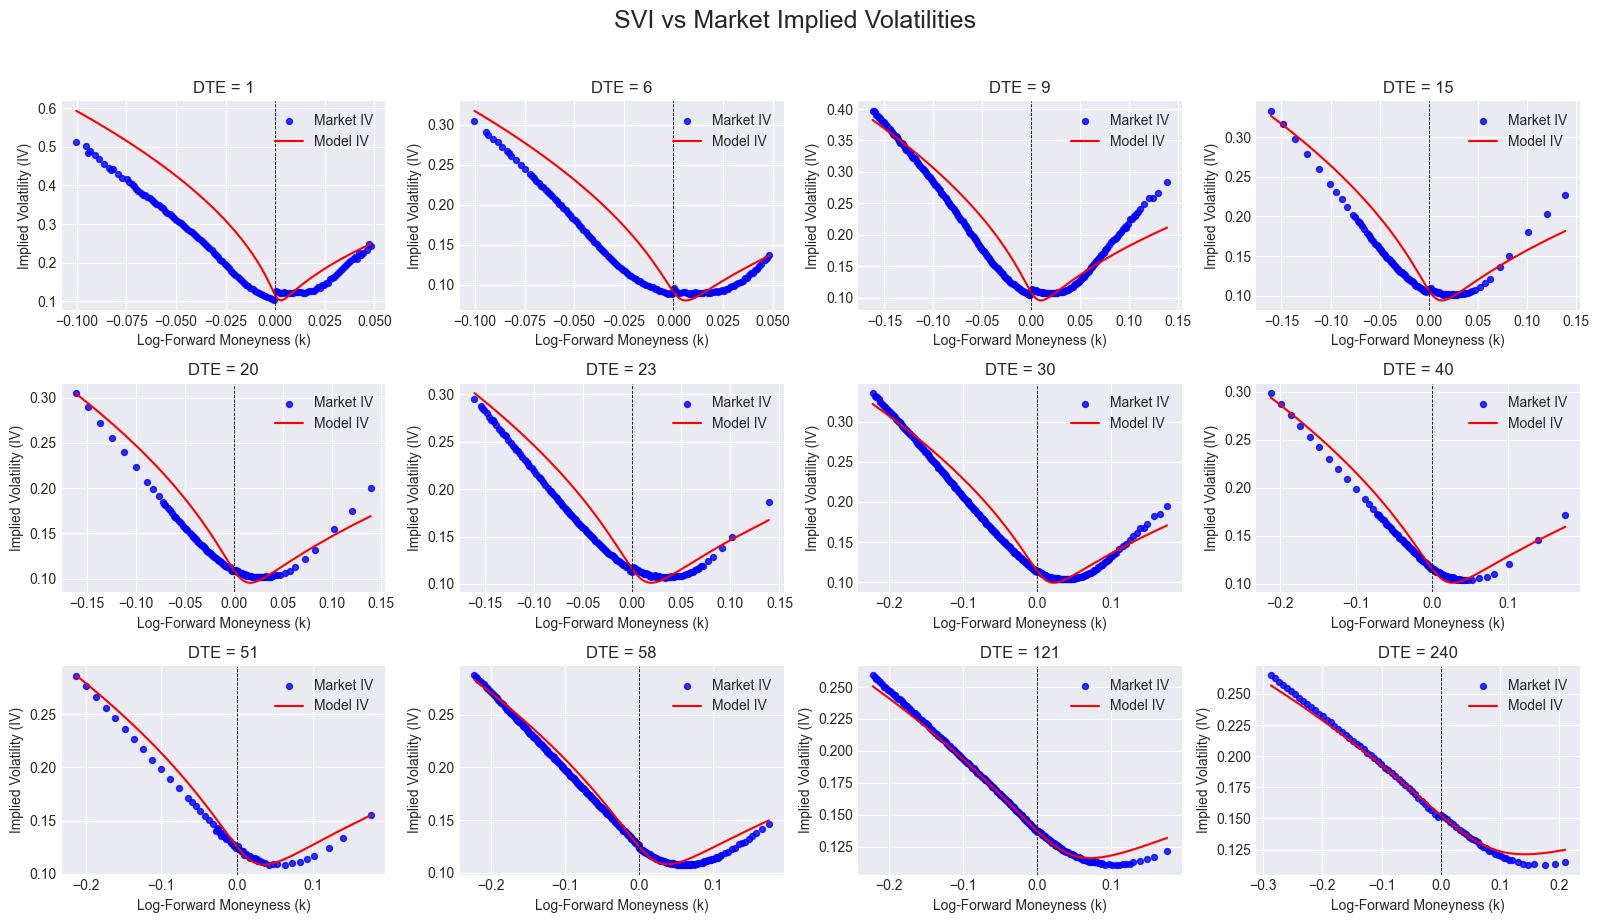

In [66]:
essvi.plot_smiles()

<Axes3D: title={'center': 'Implied Volatility Surface'}, xlabel='Strike', ylabel='DTE (days)', zlabel='Implied Vol'>

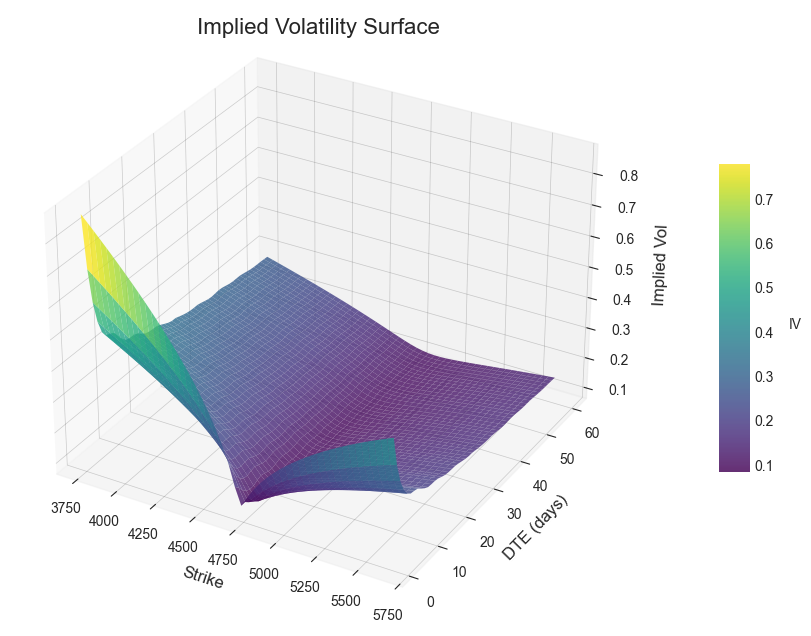

In [67]:
essvi.plot_surface()

In [68]:
essvi.check_arbitrage()

,type,T,k,value
